In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import gensim
from sklearn.model_selection import train_test_split

### Load Data

In [2]:
df_data = pd.read_csv('./Data/data_processed.csv').dropna()
le = preprocessing.LabelEncoder()
df_data['class'] = le.fit_transform(df_data.genre)
df_data

,title,genre,summary,clean_text,clean_title,class
0,Drowned Wednesday,fantasy,Drowned Wednesday is the first Trustee among ...,drown wednesday first trustee among morrow day...,drown wednesday,1
1,The Lost Hero,fantasy,"As the book opens, Jason awakens on a school ...",book open jason awakens school bus unable reme...,lose hero,1
2,Thendara House,fantasy,The novel concerns the dwelling of the Darkov...,novel concern dwell darkovan order renunciates...,thendara house,1
3,The Thief,fantasy,"Gen is released from prison by the magus, the...",gen release prison magus king scholar magus fi...,thief,1
4,The Sweet Far Thing,fantasy,The prologue begins with two men who are sear...,prologue begin two men search river london thr...,sweet far thing,1
...,...,...,...,...,...,...
2995,The Time Traveler's Wife,fantasy,This is the extraordinary love story of Clare ...,extraordinary love story clare henry meet clar...,time traveler wife,1
2996,Fantastic Beasts and Where to Find Them: The O...,fantasy,J.K. Rowling's screenwriting debut is captured...,j k rowling screenwriting debut capture exciti...,fantastic beast find original screenplay,1
2997,Charlie and the Chocolate Factory,fantasy,Charlie Bucket's wonderful adventure begins wh...,charlie bucket wonderful adventure begin find ...,charlie chocolate factory,1
2998,Frostbite,fantasy,"Rose loves Dimitri, Dimitri might love Tasha, ...",rise love dimitri dimitri might love tasha mas...,frostbite,1


In [3]:
le.classes_

array(['crime', 'fantasy', 'history', 'horror', 'science', 'thriller'],
      dtype=object)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df_data[['clean_text', 'clean_title']],
                                                   df_data['class'], random_state = 42,
                                                   test_size = 0.2, stratify=df_data['class'])

### CounterVectorize

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_countvec = count_vect.fit_transform(list(X_train.clean_text)).toarray()
X_test_countvec = count_vect.transform(list(X_test.clean_text)).toarray()

In [34]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB().fit(X_train_countvec, y_train)
y_pred = clf.predict(X_test_countvec)

In [35]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
print('Accuracy is {}'.format(accuracy_score(y_test, y_pred)))
confusion_matrix(y_test, y_pred)

Accuracy is 0.7212020033388982


array([[74,  0,  6,  9,  1, 10],
       [ 2, 61, 13, 15,  5,  4],
       [ 3,  2, 83,  6,  1,  5],
       [ 6,  3,  3, 71,  4, 12],
       [ 0,  1,  5, 11, 80,  3],
       [15,  1,  6, 13,  2, 63]], dtype=int64)

In [36]:
import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

In [37]:
## NN model
class NN(nn.Module):
    def __init__(self,in_feature,out_feature):
        super().__init__()
        self.n1 = nn.Linear(in_feature,256)
        self.n2 = nn.Linear(256,128)
        self.n3 = nn.Linear(128,64)
        self.n4 = nn.Linear(64,out_feature)
    
    def forward(self, x):
        x = self.n1(x)
        x = F.relu(x)
        x = self.n2(x)
        x = F.relu(x)
        x = self.n3(x)
        x = F.relu(x)
        output = self.n4(x)
        return output
def loss_function(output,target):
    target_onehot = []
    for i in range(len(target)):
        temp = np.zeros(6)
        temp[target[i].int().cpu().detach().numpy()] = 1
        target_onehot.append(temp)
    tar_oh_np = np.array(target_onehot)
    tar_tensor = torch.tensor(tar_oh_np).to(device).float()
    return criterion(output,tar_tensor)

In [38]:
def train(model,criterion, optimizer,loss_list1,loss_list2):
    train_loss = 0
    model.train()
    for data, target in custom_trainloader:
        data, target = data.to(device), target.to(device)
        data = data.float()
        target = target.float()
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output,target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss = (train_loss)/len(custom_trainloader)
    loss_list1.append(train_loss)
    test_loss = 0
    model.eval()
    with torch.no_grad():
        for data, target in custom_valiloader:
            data, target = data.to(device), target.to(device)
            data = data.float()
            target = target.float()
            output = model(data)
            loss = loss_function(output,target)
            test_loss += loss.item() # sum up batch loss
    test_loss = (test_loss)/len(custom_valiloader)
    loss_list2.append(test_loss)
    print('Train({}): Loss: {:.4f}'.format(epoch, train_loss))


def plot_loss(losses_tr,losses_vali,upbound):
    plt.figure()
    plt.plot(list(range(len(losses_tr))), losses_tr, color='blue', linewidth=2, label='Train loss')
    plt.plot(list(range(len(losses_vali))), losses_vali, color='red', linewidth=2, label='Validation loss')
    plt.legend()
    plt.ylim(0,upbound)
    plt.xlabel('iterations')
    plt.ylabel('MSE')
    plt.grid()
    plt.show()

In [39]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, X, Y, transform = None):
        self.X = X
        self.Y = Y
        self.transform = transform

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
batch_size=256    
custom_trainset = CustomDataset(X_train_countvec,y_train.values)
custom_trainloader = torch.utils.data.DataLoader(custom_trainset, batch_size=batch_size, shuffle=True)
custom_valiset = CustomDataset(X_test_countvec,y_test.values)
custom_valiloader = torch.utils.data.DataLoader(custom_valiset, batch_size=batch_size, shuffle=True)

In [40]:
## Training the model
seed = 4
device = 'cuda'
num_epochs = 20


device = torch.device(device)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
model = NN(35781,6).to(device)
optimizer = optim.Adam(model.parameters(),lr=0.001,weight_decay=1e-8)
criterion = nn.MSELoss()
loss_tr1 = []
loss_te1 = []
for epoch in range(1, num_epochs + 1):
    train(model, criterion, optimizer,loss_tr1,loss_te1)
    #test(model, device, custom_valiloader, criterion, epoch,loss_te1)


loss_tr = [] 
loss_te = []
for i in range(len(loss_tr1)):
    loss_tr.append(loss_tr1[i])
for i in range(len(loss_te1)):
    loss_te.append(loss_te1[i])

Train(1): Loss: 0.1517
Train(2): Loss: 0.1051
Train(3): Loss: 0.0691
Train(4): Loss: 0.0427
Train(5): Loss: 0.0253
Train(6): Loss: 0.0160
Train(7): Loss: 0.0103
Train(8): Loss: 0.0076
Train(9): Loss: 0.0060
Train(10): Loss: 0.0051
Train(11): Loss: 0.0041
Train(12): Loss: 0.0036
Train(13): Loss: 0.0032
Train(14): Loss: 0.0027
Train(15): Loss: 0.0024
Train(16): Loss: 0.0024
Train(17): Loss: 0.0023
Train(18): Loss: 0.0021
Train(19): Loss: 0.0023
Train(20): Loss: 0.0021


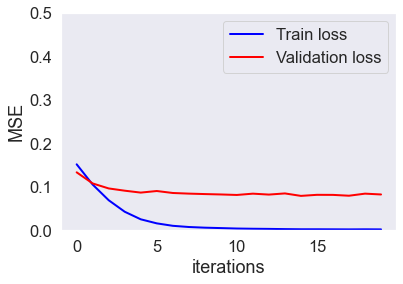

In [41]:
plot_loss(loss_tr,loss_te,.5)

In [42]:

from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred,digits=4))


              precision    recall  f1-score   support

           0     0.7400    0.7400    0.7400       100
           1     0.8971    0.6100    0.7262       100
           2     0.7155    0.8300    0.7685       100
           3     0.5680    0.7172    0.6339        99
           4     0.8602    0.8000    0.8290       100
           5     0.6495    0.6300    0.6396       100

    accuracy                         0.7212       599
   macro avg     0.7384    0.7212    0.7229       599
weighted avg     0.7387    0.7212    0.7230       599



Confusion Matrix


[Text(0.5, 61.421875, 'Predicted label'), Text(61.421875, 0.5, 'True label')]

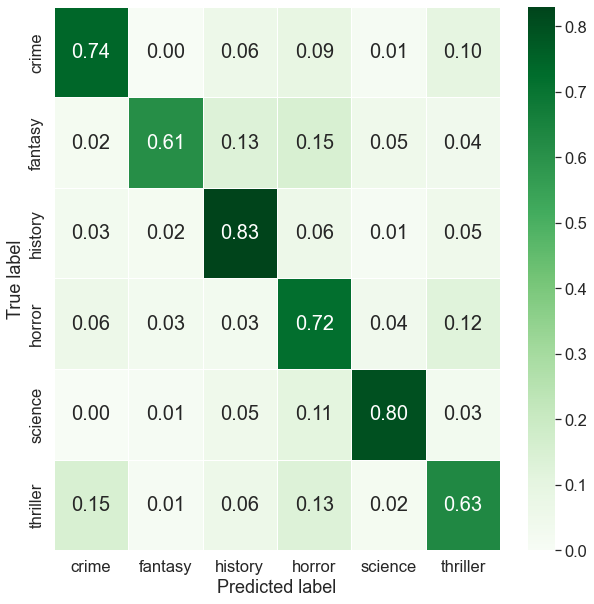

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
cm = confusion_matrix(y_test,y_pred)

#绘制confusion matrix
print("Confusion Matrix")
category_labels = ['crime', 'fantasy', 'history', 'horror', 'science', 'thriller']
cm_normalised = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(cm_normalised, annot=True, linewidths=1, square=False,
                cmap="Greens", yticklabels=category_labels, xticklabels=category_labels, vmin=0, vmax=np.max(cm_normalised),
                fmt=".2f", annot_kws={"size": 20})
ax.set(xlabel='Predicted label', ylabel='True label')

### TF-IDF

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vector = TfidfVectorizer()
X_train_tfidf = tfidf_vector.fit_transform(list(X_train.clean_text))
X_test_tfidf = tfidf_vector.transform(list(X_test.clean_text))

In [17]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB().fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
print('Accuracy is {}'.format(accuracy_score(y_test, y_pred)))
confusion_matrix(y_test, y_pred)

Accuracy is 0.7395659432387313


array([[80,  0,  5,  4,  0, 11],
       [ 3, 70, 11,  9,  4,  3],
       [ 2,  3, 86,  2,  1,  6],
       [ 7,  4,  5, 57,  4, 22],
       [ 0,  1,  6,  9, 81,  3],
       [ 9,  1,  6, 14,  1, 69]], dtype=int64)

In [19]:
class NN(nn.Module):
    def __init__(self,in_feature,out_feature):
        super().__init__()
        self.n1 = nn.Linear(in_feature,1024)
        self.n2 = nn.Linear(1024,256)
        self.n3 = nn.Linear(256,64)
        self.n4 = nn.Linear(64,out_feature)
    
    def forward(self, x):
        x = self.n1(x)
        x = F.relu(x)
        x = self.n2(x)
        x = F.relu(x)
        x = self.n3(x)
        x = F.relu(x)
        output = self.n4(x)
        return output

In [20]:
batch_size=200
custom_trainset = CustomDataset(X_train_tfidf.toarray(),y_train.values)
custom_trainloader = torch.utils.data.DataLoader(custom_trainset, batch_size=batch_size, shuffle=True)
custom_valiset = CustomDataset(X_test_tfidf.toarray(),y_test.values)
custom_valiloader = torch.utils.data.DataLoader(custom_valiset, batch_size=batch_size, shuffle=True)

In [21]:
seed = 1
device = 'cuda'
num_epochs = 20


device = torch.device(device)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
model = NN(35781,6).to(device)
optimizer = optim.Adam(model.parameters(),lr=0.001,weight_decay=1e-8)
criterion = nn.MSELoss()
loss_tr1 = []
loss_te1 = []
for epoch in range(1, num_epochs + 1):
    train(model, criterion, optimizer,loss_tr1,loss_te1)
    #test(model, device, custom_valiloader, criterion, epoch,loss_te1)


loss_tr = [] 
loss_te = []
for i in range(len(loss_tr1)):
    loss_tr.append(loss_tr1[i])
for i in range(len(loss_te1)):
    loss_te.append(loss_te1[i])

Train(1): Loss: 0.1507
Train(2): Loss: 0.1272
Train(3): Loss: 0.0868
Train(4): Loss: 0.0397
Train(5): Loss: 0.0157
Train(6): Loss: 0.0048
Train(7): Loss: 0.0024
Train(8): Loss: 0.0020
Train(9): Loss: 0.0016
Train(10): Loss: 0.0016
Train(11): Loss: 0.0015
Train(12): Loss: 0.0014
Train(13): Loss: 0.0014
Train(14): Loss: 0.0014
Train(15): Loss: 0.0014
Train(16): Loss: 0.0013
Train(17): Loss: 0.0013
Train(18): Loss: 0.0013
Train(19): Loss: 0.0014
Train(20): Loss: 0.0013


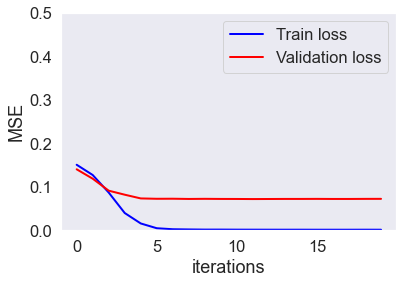

In [27]:
plot_loss(loss_tr,loss_te,.5)

In [22]:
print(classification_report(y_test,y_pred,digits=4))

              precision    recall  f1-score   support

           0     0.7921    0.8000    0.7960       100
           1     0.8861    0.7000    0.7821       100
           2     0.7227    0.8600    0.7854       100
           3     0.6000    0.5758    0.5876        99
           4     0.8901    0.8100    0.8482       100
           5     0.6053    0.6900    0.6449       100

    accuracy                         0.7396       599
   macro avg     0.7494    0.7393    0.7407       599
weighted avg     0.7496    0.7396    0.7410       599



Confusion Matrix


[Text(0.5, 61.421875, 'Predicted label'), Text(61.421875, 0.5, 'True label')]

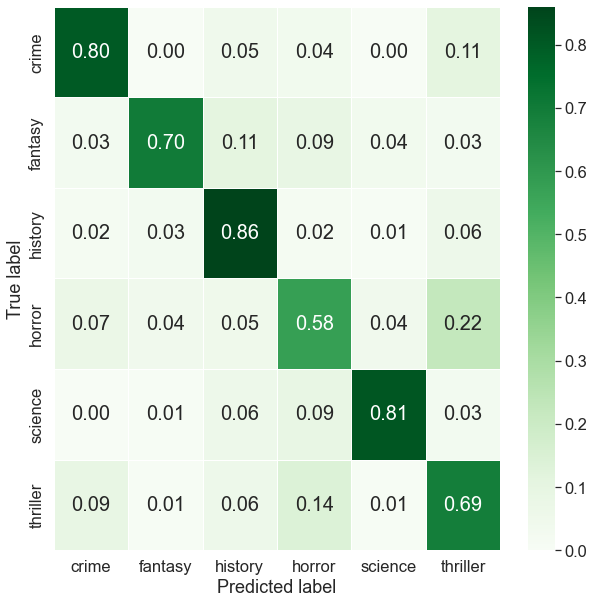

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
cm = confusion_matrix(y_test,y_pred)

#绘制confusion matrix
print("Confusion Matrix")
category_labels = ['crime', 'fantasy', 'history', 'horror', 'science', 'thriller']
cm_normalised = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(cm_normalised, annot=True, linewidths=1, square=False,
                cmap="Greens", yticklabels=category_labels, xticklabels=category_labels, vmin=0, vmax=np.max(cm_normalised),
                fmt=".2f", annot_kws={"size": 20})
ax.set(xlabel='Predicted label', ylabel='True label')

### Word2Vec

In [24]:
import gensim
from nltk import word_tokenize, sent_tokenize

sent_words = [word_tokenize(w) for w in list(X_train.clean_text)]
model = gensim.models.Word2Vec(sent_words, sg=1, vector_size =200, window=3,epochs=5,
                               min_count=3, negative=3, sample=0.001, hs=1)
model.wv.save_word2vec_format('./word2vec_model.txt', binary=False)

In [25]:
def average_word_vectors(text,model,num_features):
    vocabulary=set(w2v_model.index_to_key)
    words = word_tokenize(text)
    feature_vector=np.zeros((num_features,),dtype='float64')
    nwords=0
    for word in words:
        if word in vocabulary:
            nwords=nwords+1
            feature_vector=np.add(feature_vector,model[word])
    if nwords:
        feature_vector=np.divide(feature_vector,nwords)
    return feature_vector


def text2vector(df, w2v_model, num_features):
    # prepare vectors for train/tex=st data
    vectors = []
    for i in range(len(df)):
        val = average_word_vectors(df['clean_text'].iloc[i], w2v_model, num_features)
        vectors.append(val)
    return np.array(vectors)


w2v_model = gensim.models.KeyedVectors.load_word2vec_format('word2vec_model.txt',binary=False)
num_features = 200

In [26]:
from sklearn import svm

clf = svm.SVC().fit(text2vector(X_train, w2v_model, num_features), y_train)
y_pred = clf.predict(text2vector(X_test, w2v_model, num_features))

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
print('Accuracy is {}'.format(accuracy_score(y_test, y_pred)))
confusion_matrix(y_test, y_pred)

Accuracy is 0.674457429048414


array([[70,  1,  5,  6,  1, 17],
       [ 3, 68, 10, 10,  4,  5],
       [ 5,  8, 78,  2,  4,  3],
       [13,  9,  6, 57,  3, 11],
       [ 0,  4,  8,  8, 75,  5],
       [15,  6, 10, 10,  3, 56]], dtype=int64)

In [28]:
class NN(nn.Module):
    def __init__(self,in_feature,out_feature):
        super().__init__()
        self.n1 = nn.Linear(in_feature,64)
        self.n2 = nn.Linear(64,16)
        self.n3 = nn.Linear(16,out_feature)
    
    def forward(self, x):
        x = self.n1(x)
        x = F.relu(x)
        x = self.n2(x)
        x = F.relu(x)
        output = self.n3(x)
        return output

In [29]:
batch_size=512
custom_trainset = CustomDataset(text2vector(X_train, w2v_model, num_features),y_train.values)
custom_trainloader = torch.utils.data.DataLoader(custom_trainset, batch_size=batch_size, shuffle=True)
custom_valiset = CustomDataset(text2vector(X_test, w2v_model, num_features),y_test.values)
custom_valiloader = torch.utils.data.DataLoader(custom_valiset, batch_size=batch_size, shuffle=True)

In [30]:
seed = 1
device = 'cuda'
num_epochs = 100


device = torch.device(device)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
model = NN(200,6).to(device)
optimizer = optim.Adam(model.parameters(),lr=0.01,weight_decay=1e-8)
criterion = nn.MSELoss()
loss_tr1 = []
loss_te1 = []
for epoch in range(1, num_epochs + 1):
    train(model, criterion, optimizer,loss_tr1,loss_te1)
    #test(model, device, custom_valiloader, criterion, epoch,loss_te1)


loss_tr = [] 
loss_te = []
for i in range(len(loss_tr1)):
    loss_tr.append(loss_tr1[i])
for i in range(len(loss_te1)):
    loss_te.append(loss_te1[i])

Train(1): Loss: 0.1754
Train(2): Loss: 0.1411
Train(3): Loss: 0.1333
Train(4): Loss: 0.1252
Train(5): Loss: 0.1183
Train(6): Loss: 0.1150
Train(7): Loss: 0.1122
Train(8): Loss: 0.1090
Train(9): Loss: 0.1065
Train(10): Loss: 0.1047
Train(11): Loss: 0.1032
Train(12): Loss: 0.1012
Train(13): Loss: 0.0998
Train(14): Loss: 0.0982
Train(15): Loss: 0.0966
Train(16): Loss: 0.0950
Train(17): Loss: 0.0937
Train(18): Loss: 0.0910
Train(19): Loss: 0.0897
Train(20): Loss: 0.0880
Train(21): Loss: 0.0858
Train(22): Loss: 0.0842
Train(23): Loss: 0.0832
Train(24): Loss: 0.0819
Train(25): Loss: 0.0798
Train(26): Loss: 0.0799
Train(27): Loss: 0.0781
Train(28): Loss: 0.0773
Train(29): Loss: 0.0767
Train(30): Loss: 0.0760
Train(31): Loss: 0.0749
Train(32): Loss: 0.0741
Train(33): Loss: 0.0735
Train(34): Loss: 0.0732
Train(35): Loss: 0.0724
Train(36): Loss: 0.0716
Train(37): Loss: 0.0712
Train(38): Loss: 0.0714
Train(39): Loss: 0.0712
Train(40): Loss: 0.0701
Train(41): Loss: 0.0702
Train(42): Loss: 0.0700
T

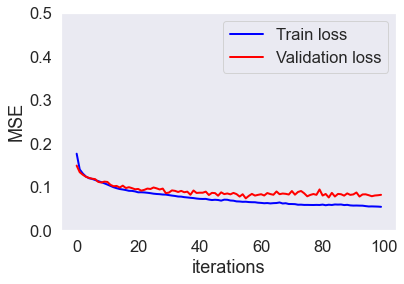

In [32]:
plot_loss(loss_tr,loss_te,.5)

In [31]:
print(classification_report(y_test,y_pred,digits=4))

              precision    recall  f1-score   support

           0     0.6604    0.7000    0.6796       100
           1     0.7083    0.6800    0.6939       100
           2     0.6667    0.7800    0.7189       100
           3     0.6129    0.5758    0.5938        99
           4     0.8333    0.7500    0.7895       100
           5     0.5773    0.5600    0.5685       100

    accuracy                         0.6745       599
   macro avg     0.6765    0.6743    0.6740       599
weighted avg     0.6766    0.6745    0.6742       599



Confusion Matrix


[Text(0.5, 61.421875, 'Predicted label'), Text(61.421875, 0.5, 'True label')]

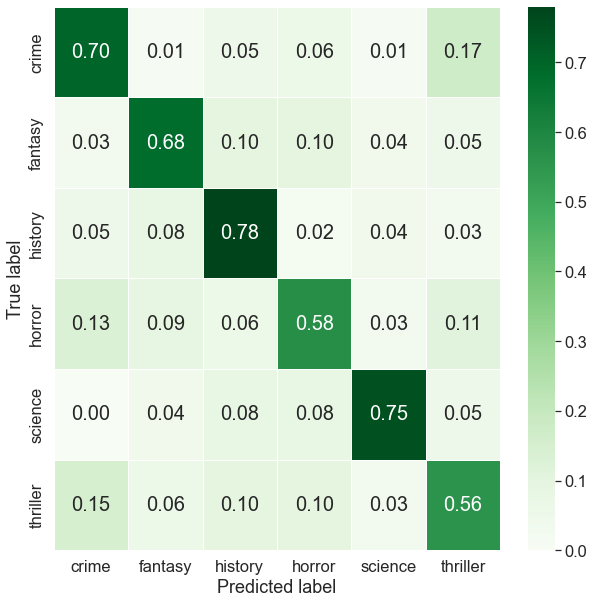

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
cm = confusion_matrix(y_test,y_pred)

#绘制confusion matrix
print("Confusion Matrix")
category_labels = ['crime', 'fantasy', 'history', 'horror', 'science', 'thriller']
cm_normalised = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(cm_normalised, annot=True, linewidths=1, square=False,
                cmap="Greens", yticklabels=category_labels, xticklabels=category_labels, vmin=0, vmax=np.max(cm_normalised),
                fmt=".2f", annot_kws={"size": 20})
ax.set(xlabel='Predicted label', ylabel='True label')